# Auteur : PAMBOU MOUBOGHA Eddy Vianney
# Etudes : Master Sciences des Donnees et Systèmes Complexes
# Ecole : Université de Strasbourg
# Sujet :  Detection de glissements de terrain

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
import elevation
plt.style.use('fivethirtyeight')

# Attributs des fichiers MM_TIO

* Lat : latitude (degré)
* Lon : longitude (degré)
* Vel : vitesse (mètre/jour)
* Topo : altitude d'un point (mètre)
* TS : serie temporelles de déplacement (mètre)

In [2]:
DATA_PATH = './donnees'

# Paramètres des géométries ascendante et descendante

In [3]:
# angle d'incidence du satellite en géométrie ascendante (angle entre la vertical et la direction du  satellite)
theta_asc = 0
# angle d'incidence du satelitte en géométrie descendante (angle entre la vertical et la direction du satellite)
theta_desc = 0
# difference angulaire des orbites des géométries ascendante et descendante
delta_alpha =  0
# déplacement le long de la ligne de visée en géométrie ascendante
d_los_asc = 0
# déplacement le long de la ligne de visée en géométrie descendante
d_los_dsc = 0
# # déplacement vertical
d_up = 0

# Chargement des données

In [4]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)

def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series


def get_ids(df, column='id'):
    
    return df[column].tolist()
        
def impute(series, ids, pc=0.4):
    
    result = []
    ids_to_not_keep = []
    n_samples = len(series[0])
    
    for i in range(len(series)):
        if 100*(series[i].isnull().sum().sum()/n_samples) < pc:
            result.append(series[i].interpolate(limit_direction='both', inplace=False))
        else:
            ids_to_not_keep.append(ids[i])
            
    return result, ids_to_not_keep

def imputed(serie, index=None):
    
    # dataframe resultat
    result = None
    
    # liste des identifiants des valeurs manquantes
    rows_with_nan = [index for index, row in serie.iterrows() if row.isnull().any()]
    
    if index is None:
        result = serie.dropna(inplace=False)
        
    if isinstance(index, list):
        pass
        
    return result, rows_with_nan
        

# imputer les données
def impute_(ns_series, ew_series, pc=0.4):

    # nombre de mésures
    n = len(ns_series[0])
    
    # recupérer les series de la composante Nord-Sud qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ns_booleans  = [True if (ns_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ns_series))]
    # recupérer les series de la composante Est-Ouest qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ew_booleans  = [True if (ew_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ew_series))]
    # Conserver uniquement les points où la norme du vecteur vitesse est calculable
    booleans     = [True if i and j else False for i, j in zip(ns_booleans, ew_booleans)]
    
    # suppression des séries temporelles qui ont un pourcentage de valeurs manquantes supérieure ou égale à 0.5
    ns_series_c = [d for d in itertools.compress(ns_series, booleans)]
    ew_series_c = [d for d in itertools.compress(ew_series, booleans)]
    
    # interpoler les valeurs manquantes des les séries restantes
    for i in range(len(ns_series_c)):
        if ns_series_c[i].isnull().sum().sum() > 0:
            ns_series_c[i].interpolate(limit_direction='both', inplace=True)
        if ew_series_c[i].isnull().sum().sum() > 0:
            ew_series_c[i].interpolate(limit_direction='both', inplace=True)
            
    return ns_series_c[0].index, ew_series_c, ns_series_c

In [14]:
class TimeSerie():
    
    def __init__(self, id_, lat, lon, topo, serie):
        self.id   = id_
        self.lat  = lat
        self.lon  = lon
        self.topo = topo
        self.serie = serie.interpolate(limit_direction='both', inplace=False)
        
    def load(self, displacement):
        return serie.dropna(inplace=False)
    
    def hasEnoughValues(self, pc):
        return True if 100*(self.serie.displacement.isnull().sum().sum()/len(self.serie)) < pc else False
        
    def normalize(self):
        return self.clone(StandardScaler().fit_transform(self.serie))
        
    def compute_inst_vel(self):
        vels =  []
        for i in range(1, len(self.serie)-1):
            duration = (self.serie.index[i+1] - self.serie.index[i-1]).days
            displacement = self.serie.iloc[i+1].values[0] - self.serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        # supprimer le premier et le dernier index (formule non applicable)
        return pd.DataFrame(vels, index=self.serie.index[1:-1], columns=['vel'])
    
    def smooth(self, ampl=2):
        
        sigma = math.sqrt(self.serie.var())
        
        for i in range(len(self.serie)):
            if abs(self.serie.iloc[i].displacement) > ampl*sigma:
                # remplacer les anomalies par des valeurs manquantes
                self.serie.iloc[i, self.serie.columns.get_loc('displacement')]= np.nan
                
        return self.clone(self.serie.interpolate(limit_direction='both', inplace=False).copy())
    
    def detect_non_moving_serie(self, alpha):
        
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((self.serie.index[0] - self.serie.index[n]).days) for n in range(len(self.serie.index))]).reshape(-1,1)
        
        # extraire la cible
        y = StandardScaler().fit_transform(self.serie)
        
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
            
        # eliminer le bruit si la regression n'est pas significative (bourrage de zeros)
        if pval > alpha:
            return self.clone(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))
                
        else:
            return self.clone(self.serie.copy())
    
    def compute_adfuller(self, ts):
    
        adf_result = adfuller(ts)
        adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, value in adf_result[4].items():
            adf_output['Critical Value (%s)'%(key)] = value

        return adf_output[1]

    def clone(self, serie):
        return TimeSerie(self.id, self.lat, self.lon, self.topo, serie)
    
    def get_days(dates):
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

    def get_Xy(self, serie):
        X = get_days(serie.index)
        y = StandardScaler().fit_transform(serie)
        return np.array(X).reshape(-1,1), y

    # lorsque la regression est non significative (p-value > 0.05), on conclut que le déplacement
    # cumulé n'est pas une fonction linéaire du temps
    # On renvoie donc un dataFrame ne contenant que des valeurs nulles
    # Il est possible q'un résultat négatif soit l'effet du bruit
    # Un débruitage est donc nécessaire avant d'utiliser cette approche !

In [12]:
class DataFromImageCorrelation(Visualization):
    
    def __init__(self, geo, ns, ew, pc=0.4, alpha=0.05):
        self.ns, self.ew  = self.load(geo, ns, ew, pc)
        self.raw_ns, self.raw_ew = self.ns[:], self.ew[:]
        self.n_cores = multiprocessing.cpu_count()
        self.magnitudes = []
        self.pc = pc
        self.alpha = alpha
    
    def load(self, geo, ns, ew, pc):
        ns_r, ew_r = [], []
        for i in range(len(ns)):
            # vérifier que les séries temporelles comporte un pourcentage de valeurs null inférieure à pc et on des id identiques
            if ns[i].isnull().sum().sum()/len(ns[i]) < pc:
                ns_r.append(TimeSerie(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ns[i]))
                ew_r.append(TimeSerie(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ew[i]))
        return ns_r, ew_r
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def compute_magnitude(self, boolean):
        
        magnitudes = []
        ns_vel_ts = None
        ew_vel_ts = None
        
        if boolean:
            ns_vel_ts = self.compute_inst_vels(self.raw_ns)
            ew_vel_ts = self.compute_inst_vels(self.raw_ew)
        else:
            ns, ew    = self.transform()
            ns_vel_ts = self.compute_inst_vels(ns)
            ew_vel_ts = self.compute_inst_vels(ew)
            
        for i in range(len(ns_vel_ts)):
            vels = []
            column = ns_vel_ts[0].columns[0]
            for ns_component, ew_component in zip(ns_vel_ts[i][column], ew_vel_ts[i][column]):
                vels.append(self.compute_vel(ns_component, ew_component))
            df = pd.DataFrame(vels, index=ns_vel_ts[0].index, columns=['magnitude'])
            magnitudes.append(df)
            
        return magnitudes
            
    def compute_inst_vel(self, ts):
        
        vels =  []
        for i in range(1, len(ts.serie)-1):
            duration = (ts.serie.index[i+1] - ts.serie.index[i-1]).days
            displacement = ts.serie.iloc[i+1].values[0] - ts.serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        # supprimer le premier et le dernier index (formule non applicable)
        return pd.DataFrame(vels, index=ts.serie.index[1:-1], columns=['vel'])
    
    def compute_inst_vels(self, ts):
        
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(self.compute_inst_vel, ts)
            return results
    
    # attention pas de normalisation dans cette méthode (car elle est utilise pour le calul de vitesse)
    def transform(self):
        ns, ew = [], []
        for n in range(len(self.ns)):
            ns.append( self.ns[n].smooth().detect_non_moving_serie(self.alpha) )
            ew.append( self.ew[n].smooth().detect_non_moving_serie(self.alpha) )
        return ns, ew
    
    # renvoyer les données pour effectuer le clustering
    # si on n'interesse qu'à la forme, il faut normaliser les données
    def prepare(self):
        magnitudes = self.compute_magnitude(False)
        #return magnitudes
        return np.array([StandardScaler().fit_transform(df).reshape(len(df)) for df in magnitudes])

In [10]:
def compute_distances_matrix(series):
    
    # initialisation de la matrix des distances
    distances_matrix = np.zeros(shape=(len(series), len(series)))
    
    # calcul des distances et remplissage de la matrice de distance
    for n in range(len(series)):
        for m in range(n, len(series)):
            if n!=m:
                dist = dtw.distance(np.array(series[n]), np.array(series[m]))
                distances_matrix[n, m] = dist
                distances_matrix[m, n] = dist
            
    return distances_matrix

In [8]:
class Visualization():
    
    def __init__(self):
        pass
    
    def plot_displacement(self, ts):
        
        days = get_days(ns_ts.index)
        fig, ax = plt.subplots(figsize=(15,5))
    
        ax[0].plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
        ax[1].plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
        
        plt.legend()
        plt.legend(loc='best')
        plt.show()
    
    def plot_displacement_vel(self, ns_ts, ew_ts):
        
        days = get_days(ns_ts[0].index)

        fig, ax_left = plt.subplots(figsize=(15,5))
        ax_right = ax_left.twinx()

        p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
        p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

        ax_left.set_xlabel("number of days since the first measure")
        ax_left.set_ylabel("displacement")
        ax_right.set_ylabel("velocity")

        lns = [p1, p2]

        ax_left.legend(handles=lns, loc='best')
        fig.tight_layout()
        plt.show()
    
    
    def plot_disp_vel(self, ns_ts, ew_ts, vels):

        fig, ax = plt.subplots(3, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()

        ax[2].plot(vels, color='green', label='velocity (m/day)', marker='o', linewidth=2)
        ax[2].set_title('Velocity magnitude')
        ax[2].set_xlabel('time')
        ax[2].set_ylabel('velocity')
        ax[2].legend()

        fig.tight_layout()
        plt.show()
        
    def plot_series(series, num_rows=4, num_cols=5, colormap='tab20'):
        
        plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

        for num_row in range(num_rows):
            for num_col in range(num_cols):
                if num_row*num_cols + num_col < len(series):
                    axs[num_row, num_col].plot(series[num_row*num_cols + num_col], color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                    #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

        plt.show()

In [7]:
class Utility():
    
    def __init__(self):
        pass

    def get_season(self, date):
        
        for season in seasons:
            name  = season[0]
            start = season[1].replace(year=date.year)
            end   = season[2].replace(year=date.year)
            if start <= date <= end
                return name
            
    def count_samples_per_season(self, dates):
    
        samples_per_season = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
        for date in dates:
            samples_per_season[get_season(date)] += 1

        return samples_per_season
    
    def get_days(self, dates):
        
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

SyntaxError: invalid syntax (<ipython-input-7-0508635d9d2a>, line 12)

In [9]:
# chargement de la composante  Est-Ouest du mouvement du sol
df_ew, df_ew_ts = load_data('MM_TIO_EW_31TGK_20151227_to_20200906.csv')
# chargement de la composante Nord-Sud du mouvement du sol
df_ns, df_ns_ts = load_data('MM_TIO_NS_31TGK_20151227_to_20200906.csv')

# Visualisation

In [121]:
df_ns[['Lat','Lon']].to_csv('geo.csv', index=False)

In [15]:
n = 3000
Data = DataFromImageCorrelation(df_ew.head(n), df_ns_ts[:n], df_ew_ts[:n])

In [ ]:
# visualisation des vitesses brutes (calculées à partir des déplacement brutes)
n = 0
raw_magnitudes = Data.compute_magnitude(True)
viz = Visualization()
viz.plot_disp_vel(Data.ns[n].serie, Data.ew[n].serie, raw_magnitudes[n])

In [ ]:
import os 
dem_path = os.path.join(os.getcwd(), '/Dem/31TGK_copernicus_dem.tif')
elevation.clip(bounds=(-122.4, 41.2, -122.1, 41.5), output=dem_path)

In [110]:
# data preparation for clustering (anomaly detection and interpolation, non moving pixels detection)
#ns, ew  = Data.prepare()

# Calcul des profils de vitesse

In [ ]:
# calcul des profils de vitesse
magnitudes = Data.compute_magnitude(False)

In [16]:
X = Data.prepare()

In [313]:
#from datetime import datetime
Y = 2000
seasons  = [('winter', date(Y,  1,  1), date(Y,  3, 20)),
           ('spring', date(Y,  3, 21),  date(Y,  6, 20)),
           ('summer', date(Y,  6, 21),  date(Y,  9, 22)),
           ('autumn', date(Y,  9, 23),  date(Y, 12, 20)),
           ('winter', date(Y, 12, 21),  date(Y, 12, 31))]

        
def plot_pie(labels, values):

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()
    
def plot_displacement(ns_ts, ew_ts):
    
    days = get_days(ns_ts.index)
    fig, ax = plt.subplots(figsize=(15,5))
    
    ax.plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
    ax.plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
    
    plt.legend(loc='best')
    
def plot_displacement_velocity(ns_ts, ew_ts):

    days = get_days(ns_ts[0].index)

    fig, ax_left = plt.subplots(figsize=(15,5))
    ax_right = ax_left.twinx()

    p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
    p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

    ax_left.set_xlabel("number of days since the first measure")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2]

    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()

# Clustering par Densité

## HDBSCAN

In [30]:
def plot_distribution(labels):
    
    v_count = dict()
    
    for label in labels:
        if label != -1:
            if label in v_count.keys():
                v_count[label] += 1
            else:
                v_count[label] = 1
            
    pd.Series({k: v for k, v in sorted(v_count.items(), key=lambda item: item[1])}).plot(kind='bar')
    
    return v_count
    
def get_data_from_class(series, labels, num_label):
    
    data = []
    
    for i in range(len(labels)):
        if labels[i] == num_label:
            data.append(series[i])
            
    return data

def visualize_cluster():
    pass

In [19]:
from sklearn.manifold import TSNE
import hdbscan

/home/eost-user/miniconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


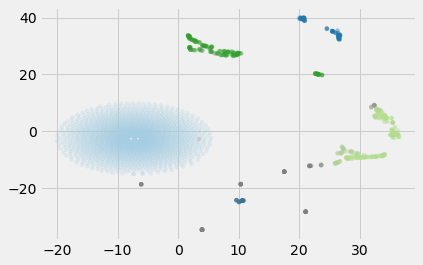

In [20]:
# Normalisation
#X =  np.array([StandardScaler().fit_transform(df).reshape(len(df)) for df in X])

projection = TSNE().fit_transform(X)

# il y a problème d'indice pour les couleurs de la palette
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True).fit(X)

color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=20, c=cluster_member_colors , linewidth=0, alpha=0.25)
plt.show()

{0: 2059, 1: 167, 3: 265, 2: 372}

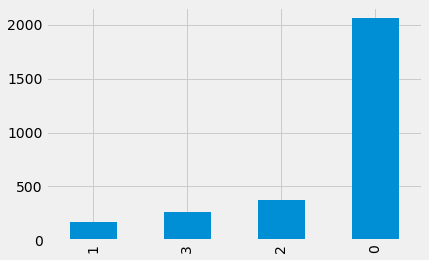

In [173]:
plot_distribution(clusterer.labels_)

In [37]:
def plot_cluster_result(data, labels, n_cols=3):
    
    n_clusters = labels.max() + 1
    n_rows = int(n_clusters / n_cols) if n_clusters % n_cols == 0 else int(math.ceil(n_clusters / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))
    for num_cluster in range(n_clusters):
        means = []
        for serie_index in range(len(data)):
            if labels[serie_index] == num_cluster:
                means.append(np.array(data[serie_index].serie))
                axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(data[serie_index].serie, c='blue', alpha=0.2)
        axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        #axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(np.average(np.vstack(means), axis=0), c='red', alpha=0.2
    fig.tight_layout()

import csv
# créer un fichier csv contenant les champs : id, lat, lon, numero de la classe
def save_clustering_result(data, labels):
    
    fieldnames = ['id', 'Lat', 'Lon', 'cluster']
    rows = []
    
    for n in range(len(data)):
        rows.append({'id': int(data[n].id), 'Lat': data[n].lat, 'Lon': data[n].lon, 'cluster': labels[n]})
    
    with open('clustering_result.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

In [38]:
save_clustering_result(Data.ns, clusterer.labels_)

In [39]:
df = pd.read_csv('clustering_result.csv')

In [ ]:
#labels = [n for n in clusterer.labels_]
plot_cluster_result(Data.ns, clusterer.labels_)

## HDBSCAN

In [73]:
def plot_kmeans_clusters_shape(data, km, n_cols=3):
    
    n_rows = int(km.n_clusters / n_cols) if km.n_clusters % n_cols == 0 else int(math.ceil(km.n_clusters / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))

    for num_cluster in range(km.n_clusters):
        for serie_index in range(len(data)):
            if km.labels_[serie_index] == num_cluster:
                axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(data[serie_index], c="blue", alpha=0.2)

        axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(km.cluster_centers_[num_cluster].ravel(), "r-")
        axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        

## Kmeans

In [38]:
def compute_distances_matrix(series):
    
    # initialisation de la matrix des distances
    distances_matrix = np.zeros(shape=(len(series), len(series)))
    
    # calcul des distances et remplissage de la matrice de distance
    for n in range(len(series)):
        for m in range(len(series)):
            x = series[n]['velocity'].dropna(inplace=False)
            y = series[m]['velocity'].dropna(inplace=False)
            dist = dtw.distance(x, y)
            distances_matrix[n, m] = dist
                
    return distances_matrix

# Classification des séries temporelles

In [37]:
# recherchons une source
# S = WX
transformer.components_.shape #(20, 87)
# calculons l'activité d'une source
source = np.dot(X, transformer.components_[0])
# passage de S à X
np.dot(transformer.mixing_[:,0], source)

NameError: name 'transformer' is not defined

In [30]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

X, _ = load_digits(return_X_y=True)
transformer = FastICA(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(1797, 7)

## Décomposition en composantes indépendantes

# Significativité des régressions linéaires
* p-value : probabilité que la pente soit nulle
* Hypothèse nulle HO : la pente de la droite de regression est nulle  (vitesse moyenne non significative)
* si la p-value est inférieure à 0.05 alors l'hypothèse nulle est rejetée (vitesse moyenne est significative).

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.api import add_constant
import statsmodels.api as sm

In [90]:
def get_days(dates):
    days = []
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def get_xy(serie):
    X = get_days(serie.index)
    y = StandardScaler().fit_transform(serie)
    return np.array(X).reshape(-1,1), y

def compute_linear_regression(X,y):
    
    X_ = add_constant(X)
    mod = sm.OLS(y,X_)
    fii = mod.fit()
    
    return fii.params, fii.pvalues

def compute_slope(displacement, days):
    
    return  np.cov(displacement, days)[0][1] / np.var(np.array(days))

## Test de Dickey-Fuller augmenté (ADF)
La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

# Réechantillonage des données

# Etude de la saisonnalité

In [ ]:
import simplekml
kml=simplekml.Kml()
style = simplekml.Style()
style.labelstyle.color = simplekml.Color.red  
style.labelstyle.scale = 2
style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
for index, row in df.iterrows():
    kml.newpoint(name=row['Vel'], coords=[(row['Lat'], row['Lon'], row['Topo'])])
kml.save('ps.kml')  